In [27]:
from lighter import Value, draw_dot
import matplotlib
%matplotlib inline


In [103]:
import math
from graphviz import Digraph


class Value:
    def __init__(self, data, _children=(), label="", _op="") -> None:
        self.data = data
        self._prev = set(_children)
        self.label = label
        self.grad = 0
        self._op = _op
        self._backward = lambda: None

    def backward(self):
        self.grad = 1
        topological = []
        visited = set()
        def build_topological(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topological(child)
                topological.append(node)
        build_topological(self)

        for node in reversed(topological):
            node._backward()


    def __repr__(self) -> str:
        return f"Value(data={self.data}) | children={self._prev} | Label:{self.label} "

    def __add__(self, other):
        # out = a + b
        # dou/da = grad_out * (1)

        x = self.data + other.data
        out = Value(x, _children=(self, other), _op="+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
            
        return out

    def __mul__(self, other):
        # out = a * b
        # dy/da =  dy/dout * dout/da = b * out.grad 
        # dout/db = a
        out = Value(self.data * other.data, _children=(self, other), _op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        out = Value(self.data**other, _children=(self,), _op=f"**{other}")
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t)
        return out


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


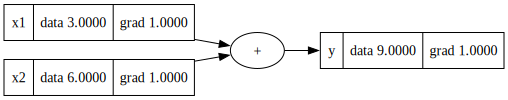

In [104]:
x1 = Value(3.0, label="x1")
x2 = Value(6.0, label="x2")


y = x1 + x2
y.label = "y"
y.grad = 1
y._backward()

draw_dot(y)

In [115]:
w1 = Value(10.0 + 1, label="w1")
w2 = Value(23.0, label="w2")
b = Value(0.3, label="b")


def func(w1, w2, b):
    x1 = Value(3.0, label="x1")
    x2 = Value(6.0, label="x2")

    s1 = (x1 * w1); s1.label="s1"
    s2 = (x2 * w2); s2.label="s2"
    o = ( s1 + s2); o.label="o"
    y =  o + b
    y.label="y"
    return y


# y.backward()
# y.grad = 1
# y._backward()
# o._backward()
# s2._backward()
# s1._backward()

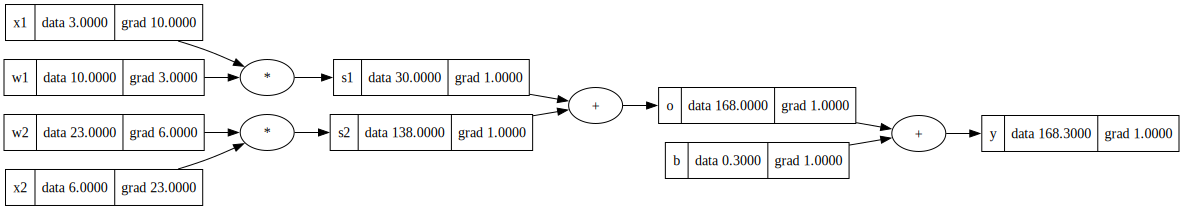

In [112]:
draw_dot(y)

In [113]:
for dw1, dw2, b in zip(w1,w2,b):
    w1 = w1 - w1.grad
    w2 = w2 - w2.grad
    b = b - b.grad

3.0

In [116]:
k fsy

Value(data=171.3) | children={Value(data=171.0) | children={Value(data=33.0) | children={Value(data=3.0) | children=set() | Label:x1 , Value(data=11.0) | children=set() | Label:w1 } | Label:s1 , Value(data=138.0) | children={Value(data=23.0) | children=set() | Label:w2 , Value(data=6.0) | children=set() | Label:x2 } | Label:s2 } | Label:o , Value(data=0.3) | children=set() | Label:b } | Label:y 